In [197]:
import numpy as np
import cv2 as cv

In [198]:
cameraIntrinsic = np.mat(
    [
        [505.5321815016914, 0.0, 269.2192266946945],
        [0.0, 504.69511487917396, 245.49264677712156],
        [0.0, 0.0, 1.0]
    ]
)
cameraDistort = np.mat(
    [0.18060252352042194, -0.5241826257387341, -0.002877771428852056, -0.017668640556835626, 0.21195474367320857]
)
invertion = np.mat(
    [
        [1.0, 0.0, 0.0],
        [0.0, -1.0, 0.0],
        [0.0, 0.0, 1.0]
    ]
)

In [199]:
cameraIntrinsic

matrix([[505.5321815 ,   0.        , 269.21922669],
        [  0.        , 504.69511488, 245.49264678],
        [  0.        ,   0.        ,   1.        ]])

In [200]:
uv_new = cv.undistortPoints(np.array([[[413.5, 330.5]]]), cameraIntrinsic, cameraDistort, P=cameraIntrinsic)
uv_new = np.concatenate((uv_new.reshape(2,1), [[1]]), axis=0)
uv_new

array([[414.0891276 ],
       [330.42744304],
       [  1.        ]])

In [201]:
normCameraCoordinates = np.matmul(np.linalg.inv(cameraIntrinsic), uv_new)
normCameraCoordinates

matrix([[0.2865691 ],
        [0.16828932],
        [1.        ]])

In [177]:
def returnRotMatrix(radians):
    rotMatrix = np.array(
        [
            [1, 0, 0],
            [0, np.cos(radians), -np.sin(radians)],
            [0, np.sin(radians), np.cos(radians)]
        ]
    )
    return rotMatrix
temp = np.matmul(np.linalg.inv(returnRotMatrix(np.radians(-30))), normCameraCoordinates) 
temp

matrix([[ 0.2865691 ],
        [-0.64574282],
        [ 0.78188075]])

In [181]:
differential_height = 1.7-0.83
scaling_factor = differential_height / float(temp[1])
scaling_factor

-1.347285587781361

In [182]:
tvec = temp * scaling_factor
tvec

matrix([[-0.38609041],
        [ 0.87      ],
        [-1.05341666]])

In [183]:
print("Final Translation: X %.5fm, Y %.5fm" % (float(tvec[2][0]), float(tvec[0][0])))

Final Translation: X -1.05342m, Y -0.38609m


# Define One-for-all Vision Function

In [215]:
from wpimath.geometry import Translation2d, Rotation2d
import math

def returnRotMatrix(radians):
    rotMatrix = np.array(
        [
            [1, 0, 0],
            [0, np.cos(radians), -np.sin(radians)],
            [0, np.sin(radians), np.cos(radians)]
        ]
    )
    return rotMatrix

def calculateTranslationFromPoint(u, v, diff, angle):
    uv_new = cv.undistortPoints(np.array([[[float(u), float(v)]]]), cameraIntrinsic, cameraDistort, P=cameraIntrinsic)
    uv_new = np.concatenate((uv_new.reshape(2,1), [[1]]), axis=0)
    normCameraCoordinates = np.matmul(invertion, np.matmul(np.linalg.inv(cameraIntrinsic), uv_new))
    temp = np.matmul(np.linalg.inv(returnRotMatrix(np.radians(angle))), normCameraCoordinates)
    
    scaleFactor = diff / float(temp[1])
    distance = math.hypot(float(temp[2]), float(temp[0])) * scaleFactor
    diffAngle = Rotation2d(float(temp[2]), float(temp[0]))
    return Translation2d(distance=distance, angle=diffAngle)
    

In [208]:
calculateTranslationFromPoint(600,480,1.70-0.83,30.0)

[[ 0.76970663]
 [-0.5369291 ]
 [ 1.        ]]
[[0.76970663]
 [0.03500576]
 [1.13448995]]


Translation2d(x=28.195540, y=19.129561)

In [212]:
true_values = [
    [1.0, 0.35, 413.5, 330.5],
    [1.1, 0.35, 417, 342.5],
    [1.2, 0.35, 418.5, 352.5],
    [1.3, 0.35, 411.5, 360.5],
    [1.4, 0.35, 414.5, 368.5],
    [1.5, 0.36, 408.5, 375.5],
    [1.6, 0.36, 407.5, 381.5],
    [1.7, 0.36, 399, 387.5],
    [1.8, 0.37, 401.5, 393.5],
    [1.9, 0.38, 405, 399.5],
    [2.0, 0.40, 408.5, 404],
]

In [235]:
def matrixVisionErrorFunction(params):
    eSum = 0
    for valueSet in true_values:
        trueTranslation = Translation2d(valueSet[0], valueSet[1])
        predictedTranslation = calculateTranslationFromPoint(valueSet[2], valueSet[3], diff=1.70-params[0], angle=params[1])
        eSum += (trueTranslation - predictedTranslation).norm()
    return eSum

In [236]:
matrixVisionErrorFunction([0.7, 50])

2.470682026363574

In [238]:
import scipy.optimize as optimize

# Height, Angle To Horizontal
initial_guess = [0.83, 70]
bounds = [(0.30, 1.00), (35.0, 85.0)]
print("Before Optimization: Height %.2f m, Angle %.2f deg" % (initial_guess[0], initial_guess[1]))

# Run Optimization
result = optimize.dual_annealing(matrixVisionErrorFunction, bounds=bounds)
if result.success:
    fitted_params = result.x
    print("After Optimization: Height %.2f m, Angle %.2f deg" % (fitted_params[0], fitted_params[1]))
else:
    raise ValueError(result.message)

Before Optimization: Height 0.83 m, Angle 70.00 deg
After Optimization: Height 1.00 m, Angle 39.40 deg


In [239]:
matrixVisionErrorFunction(fitted_params)

1.8539303442250774

In [240]:
true_x = []
true_y = []
predicted_x = []
predicted_y = []
for value in true_values:
    true_x.append(value[0])
    true_y.append(value[1])
    
    temp = calculateTranslationFromPoint(value[2], value[3], 1.70 - fitted_params[0], fitted_params[1])
    predicted_x.append(temp.X())
    predicted_y.append(temp.Y())


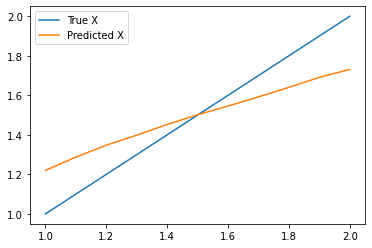

In [241]:
from matplotlib import pyplot as plt
plt.plot(true_x, true_x, label="True X")
plt.plot(true_x, predicted_x, label="Predicted X")
plt.legend()
plt.show()

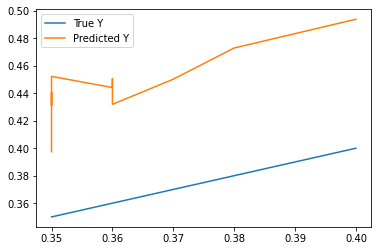

In [242]:
plt.plot(true_y, true_y, label="True Y")
plt.plot(true_y, predicted_y, label="Predicted Y")
plt.legend()
plt.show()